In [1]:
from IPython.core.display import display, HTML
import math
import pandas as pd

import mlos.global_values as global_values
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Spaces import ContinuousDimension, SimpleHypergrid
from mlos.Tracer import Tracer

display(HTML("<style>.container { width:100% !important; }</style>"))

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="OptimizerEvaluationTools", thread_id=0)

# Let's stand up the Optimizer Microservice
#
optimizer_factory = BayesianOptimizerFactory()

In [2]:
# Let's make a meta optimizer.
#
meta_optimizer_config = bayesian_optimizer_config_store.get_config_by_name("default_with_glow_worm")
meta_optimizer_config.homogeneous_random_forest_regression_model_config.n_estimators = 100
meta_optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
meta_optimizer_config.experiment_designer_config.fraction_random_suggestions = 0.2

meta_optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=meta_optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=bayesian_optimizer_config_store.parameter_space,
        objective_space=SimpleHypergrid(
            name="predictions",
            dimensions=[
                ContinuousDimension(name="optimum_value_after_100_iterations", min=-math.inf, max=math.inf)
            ]
        ),
        objectives=[Objective(name='optimum_value_after_100_iterations', minimize=True)]
    )
)

print(meta_optimizer_config.to_json(indent=2))

09/29/2020 18:19:15 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 10, "homogeneous_random_forest_regression_model_config.n_estimators": 100, "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1, "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1, "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best", "homogeneous_random_forest_regression_model_config.decision_t

{
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 100,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 0,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.min_samples_spl

In [3]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store
objective_function_config = objective_function_config_store.get_config_by_name('flower')
objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)

print(objective_function_config.to_json(indent=2))

{
  "implementation": "Flower"
}


In [4]:
print(objective_function.parameter_space)

  Name: flower
  Dimensions:
    x1: [-100.00, 100.00]
    x2: [-100.00, 100.00]


In [9]:
optimizer_config = meta_optimizer.suggest()
print(optimizer_config.to_json(indent=2))
assert False

{
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 61,
  "homogeneous_random_forest_regression_model_config.n_estimators": 47,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.7864440126725781,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.933034217569657,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.bootstrap": 1,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "friedman_mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "random",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth"

AssertionError: 

In [10]:
# Let's instantiate the optimizer. 
#
optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=objective_function.parameter_space,
        objective_space=objective_function.output_space,
        objectives=[Objective(name='y', minimize=True)]
    )
)

09/29/2020 18:20:22 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 61, "homogeneous_random_forest_regression_model_config.n_estimators": 47, "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.7864440126725781, "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.933034217569657, "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config.bootstrap": 1, "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "friedman_mse", "homogeneous_random_forest_regression_model_config.decision_tr

In [11]:
from mlos.Logger import create_logger
from mlos.Optimizers.RegressionModels.RegressionModelFitState import RegressionModelFitState

# Let us set up the lists to track optima over time.
#
best_observation_num_observations = []
best_observation_configs = []
best_observations = []

predicted_value_num_observations = []
best_predicted_value_configs = []
best_predicted_values = []

regression_model_fit_state = RegressionModelFitState()

In [12]:
logger = create_logger("Optimizer evaluation.")
i = 0

In [13]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import GoodnessOfFitMetrics, DataSetType



start_iteration_num = i
end_iteration_num = start_iteration_num + 100

for i in range(start_iteration_num, end_iteration_num):
    parameters = optimizer.suggest()
    objectives = objective_function.evaluate_point(parameters)
    logger.info(f"[{i+1}/{end_iteration_num}]Parameters: {parameters}, objectives: {objectives}")
    
    optimizer.register(parameters.to_dataframe(), objectives.to_dataframe())
    
    if optimizer.trained:
        gof_metrics = optimizer.compute_surrogate_model_goodness_of_fit()
        regression_model_fit_state.set_gof_metrics(data_set_type=DataSetType.TRAIN, gof_metrics=gof_metrics)
        
        
    
    best_observation_num_observations.append(i)
    
    best_observation_config, best_observation = optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)    
    best_observation_configs.append(best_observation_config)
    best_observations.append(best_observation)
    
    try:
        best_predicted_value_config, best_predicted_value = optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)
        best_predicted_value_configs.append(best_predicted_value_config)
        best_predicted_values.append(best_predicted_value)
        predicted_value_num_observations.append(i)
    except:
        pass
    

09/29/2020 18:20:33 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [1/100]Parameters: {"x1": -44.649588100244756, "x2": -98.85188083247482}, objectives: {"y": 110.45196789361161}
09/29/2020 18:20:34 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [2/100]Parameters: {"x1": 69.71640523177786, "x2": -78.74695709365203}, objectives: {"y": 104.6922313985914}
09/29/2020 18:20:34 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [3/100]Parameters: {"x1": 59.77436365943146, "x2": -87.37737346161674}, objectives: {"y": 104.51570569600973}
09/29/2020 18:20:34 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [4/100]Parameters: {"x1": 50.93984086563228, "x2": -24.058733570960072}, objectives: {"y": 58.29793101682778}
09/29/2020 18:20:34 -      Optimize

09/29/2020 18:20:40 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [35/100]Parameters: {"x1": 15.07157321111498, "x2": 84.45795045641097}, objectives: {"y": 87.09032630301527}
09/29/2020 18:20:40 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [36/100]Parameters: {"x1": 48.38426108716567, "x2": -68.77402305495026}, objectives: {"y": 82.81675852459377}
09/29/2020 18:20:40 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [37/100]Parameters: {"x1": 30.54227740078528, "x2": 41.96648117954135}, objectives: {"y": 53.07424798328956}
09/29/2020 18:20:40 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [38/100]Parameters: {"x1": -24.595520026137535, "x2": -63.60498448527605}, objectives: {"y": 70.18582757408507}
09/29/2020 18:20:41 -      Optimizer

09/29/2020 18:20:48 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [69/100]Parameters: {"x1": -96.71754490801294, "x2": -88.57151561687728}, objectives: {"y": 130.79603020708728}
09/29/2020 18:20:49 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [70/100]Parameters: {"x1": -3.525225503859346, "x2": -93.03181174337993}, objectives: {"y": 93.40041674964517}
09/29/2020 18:20:49 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [71/100]Parameters: {"x1": 50.67447958351215, "x2": -92.77930632008291}, objectives: {"y": 103.89724032463677}
09/29/2020 18:20:50 -      Optimizer evaluation. -    INFO - [<ipython-input-13-3f5cb82cb528>:  12 -                  <module>() ] [72/100]Parameters: {"x1": -7.308417761738738, "x2": -77.37655987847572}, objectives: {"y": 78.45663753847337}
09/29/2020 18:20:50 -      Opti

In [14]:
best_observation_config, best_observation

({"x1": -5.089816476192425, "x2": 7.288893088599082}, {"y": 7.596698404456648})

In [15]:
best_predicted_value_config, best_predicted_value

NameError: name 'best_predicted_value_config' is not defined

In [16]:
# Best observation dataframe
#
best_observation_df = pd.DataFrame([observation.to_dict() for observation in best_observations])
best_observation_df['num_observations'] = best_observation_num_observations
best_observation_df = pd.concat([best_observation_df.drop_duplicates(subset=['y'], keep='last'), best_observation_df.drop_duplicates(subset=['y'], keep='first')]).sort_index()

In [17]:
best_predicted_value_df = pd.DataFrame([predicted_value.to_dict() for predicted_value in best_predicted_values])
best_predicted_value_df['num_observations'] = predicted_value_num_observations
best_predicted_value_df = pd.concat([best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='last'), best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='first')]).sort_index()

KeyError: 'predicted_value'

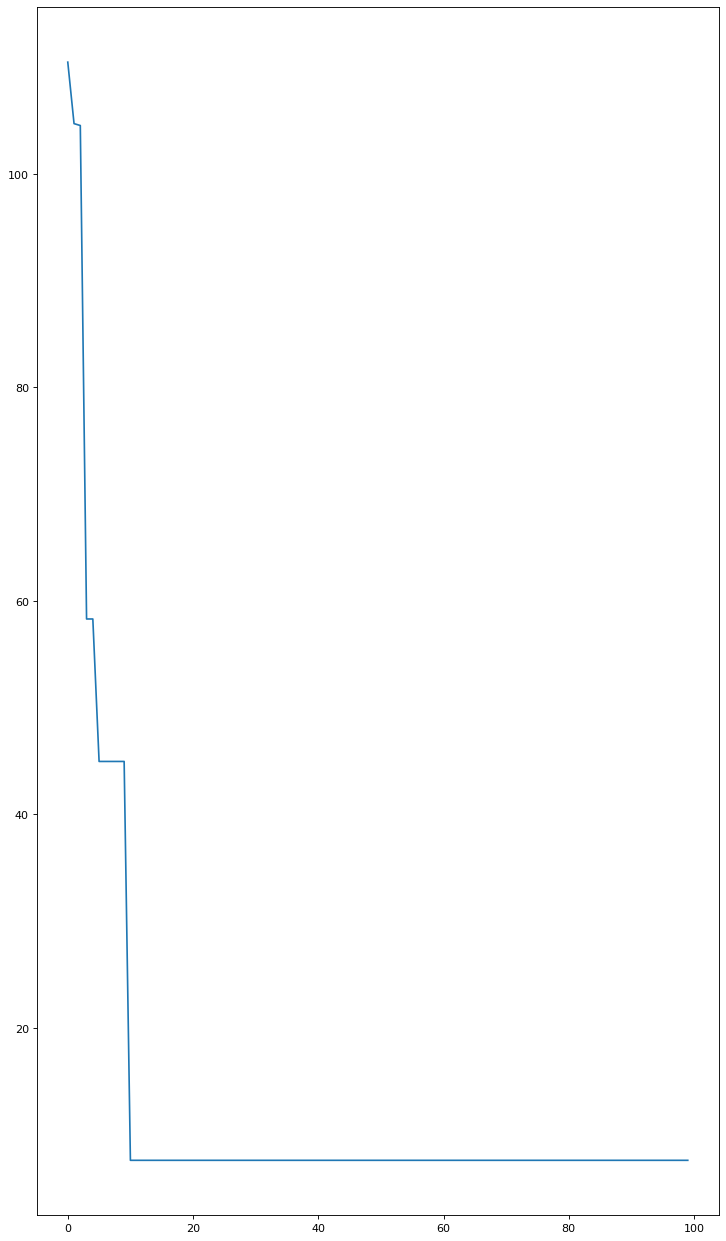

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

fig, axs = plt.subplots(1, figsize=(11, 20), dpi=80, sharex=True)

axs.plot(best_observation_df['num_observations'], best_observation_df['y'], label='y')
axs.plot(best_predicted_value_df['num_observations'], best_predicted_value_df['predicted_value'], label='predicted_value')
axs.set_ylabel('y')
axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
axs.set_xticks(best_observation_df['num_observations'][::2])
axs.grid(True)
axs.set_xlabel('num_observations')
axs.legend()  
fig.show()

In [19]:
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import DataSetType

# Let's take a look at goodness of fit data.
#
goodness_of_fit_dataframe = regression_model_fit_state.get_goodness_of_fit_dataframe(data_set_type=DataSetType.TRAIN) # TODO: add support to evaluate GoF on test data

C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


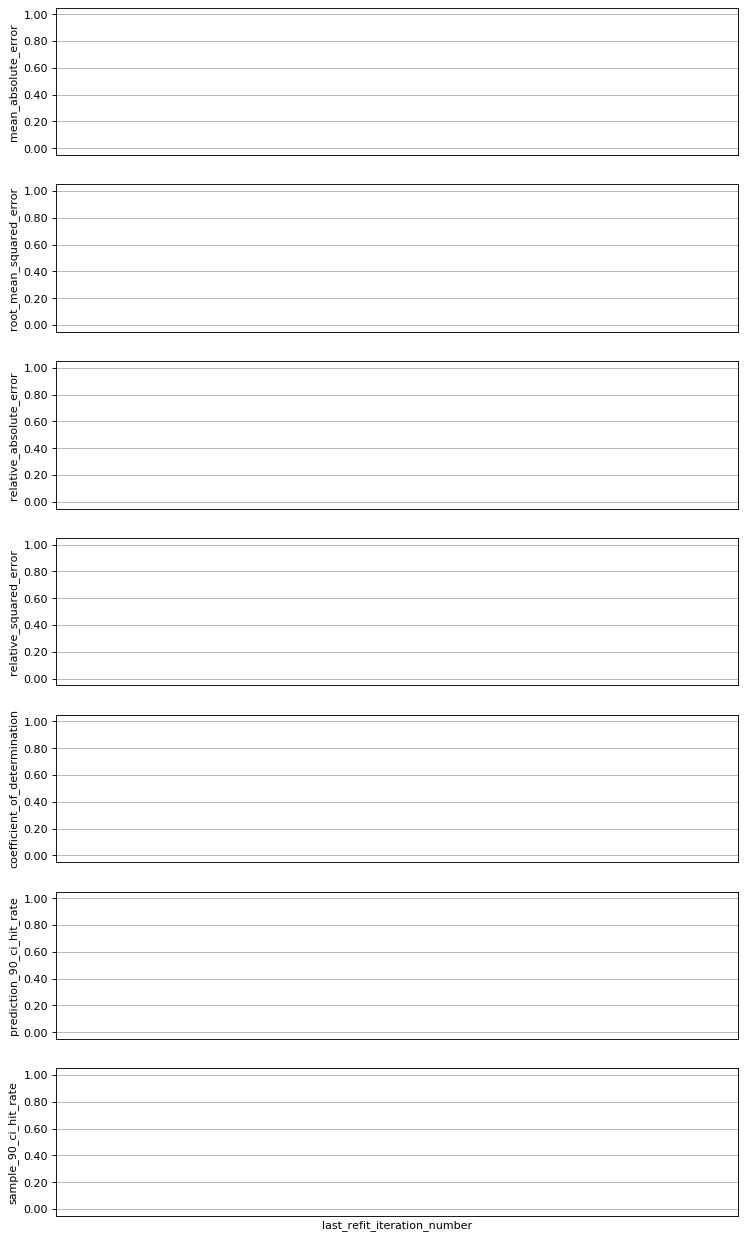

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

gof_df = goodness_of_fit_dataframe
columns_to_plot = [name for name in gof_df.columns.values if name not in ('observation_count', 'prediction_count', 'last_refit_iteration_number')]
num_plots = len(columns_to_plot)
fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    axs[i].plot(gof_df['last_refit_iteration_number'], gof_df[column], marker='o', label=column)
    axs[i].set_ylabel(column)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].set_xticks(gof_df['last_refit_iteration_number'])
    axs[i].grid(True)
    if i == num_plots - 1:
        axs[i].set_xlabel('last_refit_iteration_number')
        
fig.show()

In [ ]:
global_values.tracer.dump_trace_to_file(r"E:\code\new_mlos\source\Mlos.Python\temp\optimizer_evaluation_tools.json")

## TODO: Bayesian Optimizer Evaluation

1. Perform optimizer convergence evaluation on some functions out of the factory:
    1. Define some named configurations for the BayesianOptimizer (surrogate model config, utility function, utility function optimizer config).
    2. Write the optimum object to:
        1. Include all observations (at first - once we know what we don't need, we can remove them)
        2. Include surrogate model predictions for all observations.
        3. Include a dataframe with the various definitions of optimum:
            1. Best observed observation.
            2. Observation with the highest:
                1. predicted mean
                2. upper confidence bound
                3. lower confidence bound
            3. Speculative optima - kick of the utility function optimizer to find configurations with:
                1. maximum predicted mean
                2. maximum upper confidence bound
                3. maximum lower confidence bound
        1. Include a dataframe with cummax of all of the 7 optima.
        2. Compare the number of iterations needed to reach the same optimum for the various optimizers.
        
    3. Train the various models on the various functions and plot all 7 optima as a function of a number of observations (repeat each experiment a few times to get the idea of stability).
    4. Progressively increase the difficulty of the optimization problems:
        1. Amount of noise.
        2. Number of dimensions.
        3. Discontinuous functions.
        4. Search spaces with more branching and nesting.
        

## TODO: Utility Function Optimizer Evaluation

This is a two-step process.
1. Evaluate these model-free optimizers on the ObjectiveFunctionBase subclasses. This should allow us to capture any bugs, and get a sense of how quickly these optimizers converge on a variety of functions.
2. Evaluate these model-free optimizers as part of the bayesian optimizer. The key difference is that the model gets refit, so the underlying function changes between optimizer invocations, but we get to use prior invocations as starting points.

3. Plot all of this :)